In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from tqdm import tqdm
import sklearn
import random

import torchvision.transforms as T
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from models.rns_dataloader import get_data, get_data_by_episode

import data_utility
import annotation_utility
import interactive_plot

import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", ".*Set a lower value for log_every_n_steps if you want to see logs for the training epoch*")
warnings.filterwarnings("ignore", ".*exists and is not empty*")
warnings.filterwarnings("ignore", ".*Checkpoint directory {dirpath} exists and is not empty*")


In [3]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

In [18]:
raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# ids = list(np.unique(raw_annotations['HUP_ID']))
ids

['HUP047',
 'HUP084',
 'HUP096',
 'HUP109',
 'HUP121',
 'HUP129',
 'HUP131',
 'HUP137',
 'HUP147',
 'HUP153',
 'HUP156',
 'HUP159',
 'HUP182',
 'HUP197',
 'HUP199',
 'HUP205',
 'RNS026',
 'RNS029']

In [29]:
data_import = data_utility.read_files(path=data_dir+'rns_data', patientIDs=ids,
                                      verbose=True)  # Import data with annotation


100%|██████████| 18/18 [00:37<00:00,  2.06s/it]


In [30]:
annotations = annotation_utility.read_annotation(annotation_path=data_dir +'full_updated_anns_annotTbl_cleaned.csv',
                                                 data=data_import, n_class=3)

In [31]:
annot[annot['Patient_ID'] == 'HUP205']

NameError: name 'annot' is not defined

In [ ]:
annot = annotations.annotations
annot_nonseizure = annot[annot['Class_Code'] == 0]
annot_seizure = annot[annot['Class_Code'] == 1]
patient_list = ['HUP047',
       'HUP059',
       'HUP084',
       'HUP096',
       'HUP101',
       'HUP108',
       'HUP109',
       'HUP121',
       'HUP127',
       'HUP128',
       'HUP129',
       'HUP131',
       'HUP136',
       'HUP137',
       'HUP143',
       'HUP147',
       'HUP153',
       'HUP156',
       'HUP159',
       'HUP182',
       'HUP192',
       'HUP197',
       'HUP199',
       'HUP205',
       'RNS021',
       'RNS022',
       'RNS026',
       'RNS029']

# patient_list = [ 'HUP137',
#        'HUP153',]

# patient_list = ['RNS026', 'HUP159', 'HUP129', 'HUP096', 'HUP182']
clip_dict = {}
# for p in patient_list:
for p in patient_list:
    # print(p)
    seizure_start_index = np.array([])
    seizure_end_index = np.array([])
    nonseizure_start_index = np.array([])
    nonseizure_end_index = np.array([])
    global_episode_index_seizure = np.array([])
    global_episode_index_nonseizure = np.array([])

    annotation_list = []

    start_index = annot[annot['Patient_ID'] == p]['Episode_Start_Index']
    end_index = annot[annot['Patient_ID'] == p]['Episode_End_Index']
    annot_start_list = annot[annot['Patient_ID'] == p]['Annotation_Start_Index']
    annot_end_list = annot[annot['Patient_ID'] == p]['Annotation_End_Index']
    j = 0
    for i in range(len(start_index)):
        if end_index.iloc[i] - start_index.iloc[i] > 0:
            initial_arr = np.zeros(end_index.iloc[i] - start_index.iloc[i])
            if len(annot_start_list.iloc[i]) > 0:
                sl_order = np.argsort(annot_start_list.iloc[i])
                sl = np.array(annot_start_list.iloc[i])[sl_order]
                el = np.array(annot_end_list.iloc[i])[sl_order]

                for si, ei in zip(sl, el):
                    initial_arr[si - start_index.iloc[i]:ei - start_index.iloc[i]] = 1
        else:
            # print(i)
            initial_arr = np.zeros(1)

        annotation_list.append(initial_arr)

    ind_arr = np.vstack(
        [start_index,
         end_index,
         start_index.index]).astype(int)

    # print(annotation_list)

    valid = np.where((ind_arr[1] - ind_arr[0]) > 500)
    combined_clip = ind_arr[:, valid].squeeze()
    annotation_list = np.array(annotation_list, dtype=object)[valid]
    try:
        combined_clip = np.vstack((combined_clip, annotation_list))
    except:
        print(annotation_list)
        print(p)

    if combined_clip.shape[1]>0:

        clip_dict[p] = combined_clip

np.save(data_dir + 'rns_test_cache/clip_dict.npy', clip_dict)

In [ ]:
from scipy.stats import mode

window_len = 1
stride = 1
concat_n = 4
for id in clip_dict.keys():
    data_import[id].set_window_parameter(window_length=window_len, window_displacement=stride)
    data_import[id].set_concatenation_parameter(concatenate_window_n=concat_n)
    window_indices, _ = data_import[id].get_windowed_data(clip_dict[id][0], clip_dict[id][1])
    import_indices = []
    import_label = []
    import_clip_indices = []
    import_start_indicies = []
    import_patient_ID = []
    for i, ind in enumerate(window_indices):
        indices = window_indices[i]+1-clip_dict[id][0][i]
        offsets = np.arange(249)
        full_indices = indices[:,0][:, np.newaxis] + offsets
        slices_no_loop = clip_dict[id][3][i][full_indices]
        mode_result = mode(slices_no_loop, axis=1)
        mode_values = mode_result.mode

        # print(mode_values)
        import_label.append(mode_values)
        import_indices.append(np.repeat(clip_dict[id][2][i], len(ind)))
        import_clip_indices.append(np.arange(len(ind)))
        import_start_indicies.append(np.repeat(clip_dict[id][0][i], len(ind)))
        import_patient_ID.append(np.repeat(id, len(ind)))

    import_label = np.hstack(import_label)
    import_indices = np.hstack(import_indices)
    import_clip_indices = np.hstack(import_clip_indices)
    import_start_indicies = np.hstack(import_start_indicies)
    import_patient_ID = np.hstack(import_patient_ID)

    data_import[id].normalize_windowed_data()
    _, concatenated_data = data_import[id].get_concatenated_data(data_import[id].windowed_data, arrange='channel_stack')

    assert np.hstack(import_label).shape[0] == concatenated_data.shape[0]

    np.save(data_dir+'rns_test_cache/' + id + '.npy', {'data': concatenated_data, 'label': import_label, 'patientID': import_patient_ID, 'indices': np.vstack([import_indices,import_clip_indices,import_start_indicies]).T})

In [ ]:
from models.rns_dataloader import RNS_Downstream
from models.SwaV import SwaV

In [22]:
import torch
import torchvision
from torch import nn

from lightly.data import LightlyDataset, SwaVCollateFunction
from lightly.loss import SwaVLoss
from lightly.loss.memory_bank import MemoryBankModule
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes


In [4]:
data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label, train_index, test_index = get_data_by_episode(data_list, split=0.8)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(train_index.shape)
print(test_data.shape)
print(test_label.shape)
print(test_index.shape)

16it [00:03,  4.32it/s]

(992,)
(992,)
(992,)
(270,)
(270,)
(270,)


In [5]:
test_index

array([array([(b'HUP197', 3403,  0, 159654), (b'HUP197', 3403,  1, 159654),
              (b'HUP197', 3403,  2, 159654), (b'HUP197', 3403,  3, 159654),
              (b'HUP197', 3403,  4, 159654), (b'HUP197', 3403,  5, 159654),
              (b'HUP197', 3403,  6, 159654), (b'HUP197', 3403,  7, 159654),
              (b'HUP197', 3403,  8, 159654), (b'HUP197', 3403,  9, 159654),
              (b'HUP197', 3403, 10, 159654), (b'HUP197', 3403, 11, 159654),
              (b'HUP197', 3403, 12, 159654), (b'HUP197', 3403, 13, 159654),
              (b'HUP197', 3403, 14, 159654), (b'HUP197', 3403, 15, 159654),
              (b'HUP197', 3403, 16, 159654), (b'HUP197', 3403, 17, 159654),
              (b'HUP197', 3403, 18, 159654), (b'HUP197', 3403, 19, 159654),
              (b'HUP197', 3403, 20, 159654), (b'HUP197', 3403, 21, 159654),
              (b'HUP197', 3403, 22, 159654), (b'HUP197', 3403, 23, 159654),
              (b'HUP197', 3403, 24, 159654), (b'HUP197', 3403, 25, 159654),
            

In [6]:
class RNS_Active_by_episode(Dataset):
    def __init__(self, data, label, transform=True, astensor=True):
        self.data = data
        self.label = label
        self.transform = transform

        self.length = len(self.data)

        if astensor:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
                T.ToTensor()
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.ToTensor()
            ])
        else:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
            ])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        data_arr = self.data[index]
        label_arr = self.label[index]


        data_arr_out = []

        for i, data in enumerate(data_arr):
            if self.transform:
                concat_len = data.shape[1] / 4
                channel_index = np.arange(4)
                np.random.shuffle(channel_index)
                channel_index = channel_index * concat_len + (concat_len - 1) / 2
                channel_index = np.repeat(channel_index, concat_len)
                concate_len_1 = (concat_len - 1) / 2
                a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
                base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
                channel_index = channel_index + base_repeat
                data = data[channel_index.astype(int)]
                data = torch.from_numpy(data).clone()
                data = data.repeat(3, 1, 1)
                data = self.augmentation(data)
                data_arr_out.append(data)

            else:
                concat_len = data.shape[1] / 4
                channel_index = np.arange(4)
                # np.random.shuffle(channel_index)
                channel_index = channel_index * concat_len + (concat_len - 1) / 2
                channel_index = np.repeat(channel_index, concat_len)
                concate_len_1 = (concat_len - 1) / 2
                a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
                base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
                channel_index = channel_index + base_repeat
                data = data[channel_index.astype(int)]
                data = torch.from_numpy(data).clone()
                data = data.repeat(3, 1, 1)
                data = self.totensor(data)
                data_arr_out.append(data)

        data_arr_out = torch.stack(data_arr_out)

        return data_arr_out, torch.from_numpy(label_arr).to(dtype=torch.long), None

In [7]:
def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    sequence_len = [dt.size(0) for dt in data]

    return torch.concat(data), torch.concat(label), sequence_len

In [8]:
from models.LSTMDownStream import SupervisedDownstream
from sigmoid_loss import sigmoid_focal_loss
from models.SwaV import SwaV

In [9]:
swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = SupervisedDownstream(swav.backbone)

del swav

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',
                                                   filename='rns_swav_50_all_linear_eval-{epoch:02d}-{val_loss:.5f}', save_last=True, save_top_k=-1, dirpath=ckpt_folder_root + 'rns_swav_50_all_linear_eval')
csv_logger = pl_loggers.CSVLogger(log_folder_root, name='rns_swav_50_all_linear_eval')

trainer = pl.Trainer(logger=csv_logger, max_epochs=80, callbacks=[checkpoint_callback], accelerator='gpu', devices=1,precision=16, check_val_every_n_epoch=None, val_check_interval = 300)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
from models.rns_dataloader import RNS_Active_by_episode_LSTM, collate_fn
train_dataset = RNS_Active_by_episode_LSTM(train_data, train_label, transform=False, astensor=True)
test_dataset = RNS_Active_by_episode_LSTM(test_data, test_label, transform=False, astensor=True)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=3,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | backbone | Sequential | 23.5 M
1 | fc1      | Linear     | 1.0 M 
2 | fc2      | Linear     | 32.8 K
3 | dp       | Dropout1d  | 0     
4 | fc3      | Linear     | 520   
5 | fc4      | Linear     | 18    
6 | softmax  | Softmax    | 0     
7 | lstm     | LSTM       | 1.6 M 
----------------------------------------
26.2 M    Trainable params
0         Non-trainable params
26.2 M    Total params
52.335    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 90. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [35]:
train_dataset.data.shape

(992,)

In [16]:
test_dataset = RNS_Downstream(test_data, test_label, transform=False, astensor=True)
val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

data loaded
(21556, 249, 36)
(21556,)


In [17]:
data_list = os.listdir(data_dir+'rns_test_cache')[1:]
# data_list = ['RNS026_seizure.npy', 'HUP159_seizure.npy', 'HUP129_seizure.npy', 'HUP096_seizure.npy','RNS026_nonseizure.npy', 'HUP159_nonseizure.npy', 'HUP129_nonseizure.npy', 'HUP096_nonseizure.npy']
class RNS_Downstream(Dataset):
    def __init__(self, file_names, transform=True, astensor=True):
        self.file_names = file_names
        self.transform = transform

        file_name_temp = self.file_names[0]
        cache = np.load(data_dir +'rns_test_cache/' + file_name_temp, allow_pickle=True)
        temp_file = cache.item().get('data')

        self.data = np.empty((0, temp_file.shape[1], temp_file.shape[2]))
        self.label = np.array([])
        print(self.data.shape)

        for name in tqdm(self.file_names):
            cache = np.load(data_dir +'rns_test_cache/' + name, allow_pickle=True)
            data = cache.item().get('data')
            label = cache.item().get('label')
            self.data = np.vstack((self.data, data))
            self.label = np.hstack((self.label, label))

        print('data loaded')

        self.label = self.label[np.newaxis].T

        self.length = len(self.data)

        if astensor:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
                T.ToTensor()
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.ToTensor()
            ])
        else:
            self.augmentation = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
                T.RandomApply([T.ColorJitter()], p=0.5),
                T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
                T.RandomInvert(p=0.2),
                T.RandomPosterize(4, p=0.2),
            ])

            self.totensor = T.Compose([
                T.ToPILImage(),
                T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
            ])


    def __len__(self):
        return self.length


    def __getitem__(self, index):
        data = self.data[index]
        label = self.label[index]

        if self.transform:
            concat_len = data.shape[1] / 4
            channel_index = np.arange(4)
            np.random.shuffle(channel_index)
            channel_index = channel_index * concat_len + (concat_len - 1) / 2
            channel_index = np.repeat(channel_index, concat_len)
            concate_len_1 = (concat_len - 1) / 2
            a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
            base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
            channel_index = channel_index + base_repeat
            data = data[channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            data = data.repeat(3, 1, 1)
            data = self.augmentation(data)

        else:
            concat_len = data.shape[1] / 4
            channel_index = np.arange(4)
            # np.random.shuffle(channel_index)
            channel_index = channel_index * concat_len + (concat_len - 1) / 2
            channel_index = np.repeat(channel_index, concat_len)
            concate_len_1 = (concat_len - 1) / 2
            a_repeat = np.arange(-concate_len_1, concate_len_1 + 1)[np.newaxis].T
            base_repeat = np.repeat(a_repeat, 4, axis=1).T.flatten()
            channel_index = channel_index + base_repeat
            data = data[channel_index.astype(int)]
            data = torch.from_numpy(data).clone()
            data = data.repeat(3, 1, 1)
            data = self.totensor(data)

        return data, torch.from_numpy(label).to(dtype=torch.long), None

dataset = RNS_Downstream(data_list, transform=False,astensor = True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

(0, 249, 36)


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]

data loaded


In [11]:
predictions = trainer.predict(model,val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 242it [00:00, ?it/s]

In [13]:
import torch.nn as nn
output_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb, _ in predictions:
    output_list.append(pred)
    target_list.append(y)
    emb_list.append(emb)

In [14]:
pred_raw = torch.vstack(output_list)
target = torch.concat(target_list)
emb = torch.concat(emb_list)
out = torch.argmax(pred_raw, dim=1)

In [26]:
[tt.size() for tt in target_list]

[torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([120]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([180]),
 torch.Size([179]),
 torch.Size([180]),
 torch.Size([178]),
 torch.Size([180]),
 torch.Size([179]),
 torch.Size([120]),
 torch.Size([120]),
 torch.Size([120]),
 torch.Size([108]),
 torch.Size([120]),
 torch.Size([84]),
 torch.Size([120]),
 torch.Size([120]),
 torch.Size([111]),
 torch.Size([120]),
 torch.Size([179]),
 torch.Size([134]),
 torch.Size([179]),
 torch.Size([179]),
 torch.Size([124]),
 torch.Size([133]),
 torch.Size([180]),
 torch.Size([179]),
 torch.Size([126]),
 torch.Size([180]),
 

In [42]:
m(pred_raw.float())[:,0]

tensor([0.9998, 0.9998, 0.9998,  ..., 0.9928, 0.9836, 0.9926])

In [43]:
len(list(np.unique(test_index)))

21530

In [23]:
index_list = []
for i in range(len(list(np.unique(test_index['episode_index'])))):

    print(i)

    index_location = np.where(test_index['episode_index'] == list(np.unique(test_index['episode_index']))[i])[0]

    # print(target[index_location[np.argsort(test_index[index_location], order=['start_index','slice_index'])]].squeeze(1))
    # print(out[index_location[np.argsort(test_index[index_location], order=['start_index','slice_index'])]])
    index_array = test_index[index_location[np.argsort(test_index[index_location], order=['start_index','slice_index'])]]
    start_ind = np.unique(index_array['start_index'])

    annot = annotations.annotations[annotations.annotations.index == np.unique(index_array['episode_index'])[0]]

    start_indexes = []
    start_indexes.extend(annot.Annotation_Start_Index.item())
    start_indexes.extend(annot.Annotation_End_Index.item())
    start_indexes.append(annot.Episode_Start_Index.item())
    start_indexes.append(annot.Episode_End_Index.item())
    # print(start_indexes)

    in_list = []
    for si in start_ind:
        in_list.append(si in start_indexes)

    assert True in in_list

# [annot.Annotation_Start_Index.item(), annot.Episode_Start_Index, ]

    # # print(annotations.annotations[annotations.annotations.index == slice_index])
    # if class_code == 0:
    #     try:
    #         assert (((start_index == annot.Episode_Start_Index) | (end_index == annot.Episode_End_Index)).item())
    #     except:
    #         print(ind)
    #         print(annot)
    #
    # elif class_code == 1:
    #     assert start_index in annot.Annotation_Start_Index.item()

0


NameError: name 'annotations' is not defined

In [15]:
sklearn.metrics.accuracy_score(torch.argmax(pred_raw, dim=1), target)

0.9043044291952589

In [16]:
clf_report = sklearn.metrics.classification_report(torch.argmax(pred_raw, dim=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.911685  0.934387  0.922896     14738
           1   0.891834  0.856667  0.873897      9307

    accuracy                       0.904304     24045
   macro avg   0.901760  0.895527  0.898397     24045
weighted avg   0.904001  0.904304  0.903930     24045



In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
len(emb)

In [ ]:
pca_comp_n = 30
batch_size = 32

pca = PCA(n_components=pca_comp_n, copy=True).fit(emb)
p = pca.transform(emb)

# ind = np.random.choice(len(emb), 10000)
#
tsne = TSNE(n_components=2, verbose=1, perplexity=75, random_state=142, init='pca')
z = tsne.fit_transform(emb)
interictal_inds = np.where(target == 0)[0]
ictal_inds = np.where(target == 1)[0]

In [ ]:
pca.explained_variance_ratio_

In [ ]:
len(interictal_inds)

In [ ]:
len(ictal_inds)

In [ ]:
# spc = p
#
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(spc[interictal_inds,0],spc[interictal_inds,1],spc[interictal_inds,2],c='gold',label= 'interictal')
# ax.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1],spc[ictal_inds, 2], c='royalblue', label='ictal')
# # plt.title('Swav Embedding t-SNE')
# ax.set_xlabel('comp 1')
# ax.set_ylabel("comp 2")
# ax.set_zlabel("comp 2")
# plt.legend()
# # plt.xlim(-67, 74)
# # plt.ylim(-67, 75)
# plt.grid()
# # plt.show()

In [ ]:
spc = p
plt.figure(figsize=(10, 8))
plt.scatter(spc[interictal_inds,0],spc[interictal_inds,1],c='gold',label= 'interictal')
plt.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1], c='royalblue', label='ictal',s=0.5)
# plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2")
plt.legend()
# plt.xlim(-67, 74)
# plt.ylim(-67, 75)
plt.grid()
plt.show()

In [ ]:
# dt = np.vstack((z[:,0], z[:,1])).T
interactive_plot.interactive_plot(z, ['RNS026', 'HUP159', 'HUP129', 'HUP096'], data_import, color_override=target)

In [ ]:
interactive_plot.interactive_plot(z, ['HUP159'], data_import, color_override=target)

In [29]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(target,m(pred_raw.float())[:,1], pos_label=1)
sklearn.metrics.auc(fpr, tpr)

0.975720551997828

In [30]:
m(pred_raw.float())[:,1]

tensor([3.8454e-05, 3.4064e-06, 3.6832e-06,  ..., 3.7266e-06, 7.6465e-06,
        2.3368e-04])

In [27]:
target

tensor([0, 0, 0,  ..., 0, 0, 0])

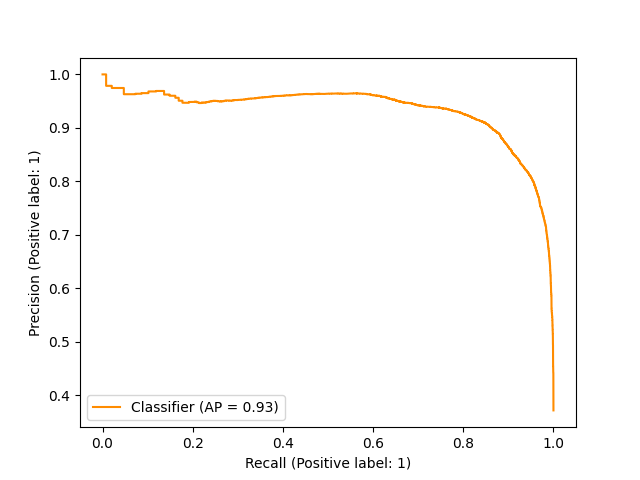

In [24]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(
    target,
    m(pred_raw.float())[:,1],
    color="darkorange",
)
# plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
# plt.hlines(y = 1, xmin = 0, xmax = 1)
# plt.vlines(x = 0, ymin = 0, ymax = 1)
# plt.axis("square")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
# plt.legend()
# plt.show()

In [ ]:
PrecisionRecallDisplay.from_predictions(
    target,
    m(pred_raw.float())[:,1],
    color="darkorange",
)
# plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(target,
    m(pred_raw.float())[:,1])
metrics.auc(fpr, tpr)

In [ ]:
output[:, 1]

In [ ]:

output = torch.argmax(output, dim=1)
output = output.detach().cpu().numpy()
target = target.squeeze().detach().cpu().numpy()

In [ ]:
import sklearn

clf_report = sklearn.metrics.classification_report(output, target, digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
for batch, label in tqdm(val_dataloader):
    batch = batch.to(device)
    label = label.to(device)
    label = F.one_hot(label).squeeze()
    outputs = model(batch)
    print(batch)
    loss = sigmoid_focal_loss(pred.float(), label.float(), alpha=0.5, gamma=8, reduction='mean')
    print(loss)
    break

In [ ]:
# import copy
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import DINOCollateFunction, LightlyDataset
# from lightly.loss import DINOLoss
# from lightly.models.modules import DINOProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.utils.scheduler import cosine_schedule
#
#
# class DINO(torch.nn.Module):
#     def __init__(self, backbone, input_dim):
#         super().__init__()
#         self.student_backbone = backbone
#         self.student_head = DINOProjectionHead(
#             input_dim, 512, 64, 2048, freeze_last_layer=1
#         )
#         self.teacher_backbone = copy.deepcopy(backbone)
#         self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
#         deactivate_requires_grad(self.teacher_backbone)
#         deactivate_requires_grad(self.teacher_head)
#
#     def forward(self, x):
#         y = self.student_backbone(x).flatten(start_dim=1)
#         z = self.student_head(y)
#         return z
#
#     def forward_teacher(self, x):
#         y = self.teacher_backbone(x).flatten(start_dim=1)
#         z = self.teacher_head(y)
#         return z
#
#
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# input_dim = 512
# # instead of a resnet you can also use a vision transformer backbone as in the
# # original paper (you might have to reduce the batch size in this case):
# # backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# # input_dim = backbone.embed_dim
#
# model = DINO(backbone, input_dim)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
#
# # # we ignore object detection annotations by setting target_transform to return 0
# # pascal_voc = torchvision.datasets.VOCDetection(
# #     "datasets/pascal_voc", download=True, target_transform=lambda t: 0
# # )
# # dataset = LightlyDataset.from_torch_dataset(pascal_voc)
# # # or create a dataset from a folder containing images or videos:
# # # dataset = LightlyDataset("path/to/folder")
#
# collate_fn = DINOCollateFunction(solarization_prob = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0)
#
# dataloader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1,
# )
#
# criterion = DINOLoss(
#     output_dim=2048,
#     warmup_teacher_temp_epochs=5,
# )
# # move loss to correct device because it also contains parameters
# criterion = criterion.to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# epochs = 10
#
# print("Starting Training")
# for epoch in range(epochs):
#     total_loss = 0
#     momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
#     for views, _, _ in tqdm(dataloader):
#         update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
#         update_momentum(model.student_head, model.teacher_head, m=momentum_val)
#         views = [view.to(device) for view in views]
#         global_views = views[:2]
#         teacher_out = [model.forward_teacher(view) for view in global_views]
#         student_out = [model.forward(view) for view in views]
#         loss = criterion(teacher_out, student_out, epoch=epoch)
#         total_loss += loss.detach()
#         loss.backward()
#         # We only cancel gradients of student head.
#         model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [ ]:
augmentation = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 512), interpolation=T.InterpolationMode.NEAREST),
    T.RandomApply([T.ColorJitter()], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(4, p=0.2),
])

data = ictal_data_X[0]

channel_index = np.arange(data.shape[0])
np.random.shuffle(channel_index)
data = data[channel_index]
data = torch.from_numpy(data).clone()
data = data.repeat(3, 1, 1)
data = augmentation(data)
data

In [ ]:
channel_index

In [ ]:
data[channel_index]

In [ ]:
data

In [ ]:
#
# print("Starting Training")
# for epoch in range(50):
#     total_loss = 0
#     i = 0
#     for batch, label in tqdm(dataloader):
#         batch = batch.to(device)
#         # print(type(batch))
#         label = label.to(device)
#         label = F.one_hot(label).squeeze()
#         outputs = model(batch)
#         loss = sigmoid_focal_loss(outputs.float(),label.float(), alpha = 0.25, gamma = 7,reduction = 'mean')
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")